zero level offset

set working enviroment

In [1]:
import sys
import os
import yaml

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp3.0_rad_offset_gain/")

import teds modules

In [2]:
from teds.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.siml1b import simplified_instrument_model_and_l1b_processor
from teds.l1l2.l1bl2 import level1b_to_level2_processor_RTorCH4, level1b_to_level2_processor

operational flags

In [3]:
proc_gm     = True
proc_sgmgeo = True
proc_sgmrad = True 
proc_siml1b = True  
proc_l1bl2  = True

GM model

In [4]:
if(proc_gm):
    #configureation file
    gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
    geometry_module(gm_config)

/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/Tango_Carbon_gm_exp3.0.nc
2024-11-30 21:16:08,352 : teds.lib.lib_utils : gm : 435 : INFO : =>gm calculation finished successfully. 


[21:16:08] =>gm calculation finished successfully. 


SGM-GEO

In [5]:
if(proc_sgmgeo):
    sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config.yaml'))

    geoscene_generation(sgmgeo_config)

=>sgm geoscene calculation finished successfully


/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/teds/lib/libGM.py:187: RuntimeWarning: invalid value encountered in divide
  cU1 * cU2 * slam / sin_sigma)


SGM-RAD

In [6]:
if(proc_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config.yaml'))
    Carbon_radiation_scene_generation(sgmrad_config)

Radiative tranfer simulation...


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

=>Carbon radsgm calculation finished successfully


Simplified L1B processor

In [7]:
if(proc_siml1b):
    siml1b_config= yaml.safe_load(open('./settings/siml1b_config.yaml'))
    simplified_instrument_model_and_l1b_processor(siml1b_config)

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

=>siml1b calculation finished successfully


L2 processing of the $\mathrm{CO_2}$ and $\mathrm{CH_4}$ proxy product

In [8]:
if(proc_l1bl2):
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    level1b_to_level2_processor_RTorCH4(l1bl2_config)
#    level1b_to_level2_processor(l1bl2_config)

RTorCH4 level 1B to level 2 processor
Trace gas concentration priors:
H2O: 1.000000e-03
CH4: 1.700000e-06
CO2: 3.000000e-04
Using 2 ACT chunks
Begin retrieval at 2024-11-30 21:16:12.039784


100%|██████████| 1/1 [00:14<00:00, 14.36s/it]


Retrieval completed in 0:00:14.363843
Writing level 2 output to /home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp3.0.nc
Writing level 2 diagnostics to /home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_diag_exp3.0.nc
=> L2 processor finished sucessfully


Analyse gains

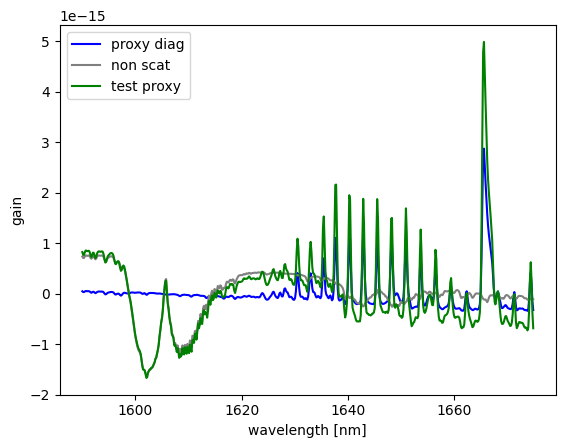

In [27]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

filel2_diag = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_diag_exp3.0.nc'
diag= Dataset(filel2_diag, mode='r')
wave = diag['wavelength'][:]
gain_ch4_ns = diag['gain CH4'][:]
gain_co2_ns = diag['gain CO2'][:]
gain_ch4_proxy = diag['gain CH4 proxy'][:]
gain_co2_proxy = diag['gain CO2 proxy'][:]
diag.variables.keys()

filel2 = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp3.0.nc'
lev2 = Dataset(filel2, mod='r')
co2_ns    = lev2['non_scattering_retrieval/XCO2']
ch4_ns    = lev2['non_scattering_retrieval/XCH4']
co2_proxy = lev2['XCO2 proxy']
ch4_proxy = lev2['XCH4 proxy']

#check proxy gain with equationa from MRD appendix
nalt,nact,nwave = wave.shape
gain_co2_test = np.zeros([nalt,nact,nwave])
gain_ch4_test = np.zeros([nalt,nact,nwave])
 
for iact in range(nact):
    gain_co2_test[0,iact,:] = (gain_co2_ns[0,iact,:]/co2_ns[0,iact] - gain_ch4_ns[0,iact,:]/ch4_ns[0,iact])*co2_proxy[0,iact]
    gain_ch4_test[0,iact,:] = (gain_ch4_ns[0,iact,:]/ch4_ns[0,iact] - gain_co2_ns[0,iact,:]/co2_ns[0,iact])*ch4_proxy[0,iact]

iact = 2
ialt = 0
plt.plot(wave[ialt, iact,:], gain_co2_proxy[ialt, iact,:],color='blue', label ='proxy diag')
plt.plot(wave[ialt, iact,:], gain_co2_ns[ialt, iact,:], color = 'gray', label = 'non scat')
plt.plot(wave[ialt, iact,:], gain_co2_test[ialt, iact,:],color = 'green', label = 'test proxy')
plt.xlabel('wavelength [nm]')
plt.ylabel('gain')
plt.legend()
